# MNIST SRGAN
Implementation of SRGAN for generating MNIST digits. This version does not include perceptual loss. To be used as a baseline for the more advanced GAN. 

The GAN is trained to upsample 7x7 MNIST images to 28x28

## Notebook setup

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as f
from torchsummary import summary
import torch.optim as optim

from torchvision import models, transforms
import torchvision

import numpy as np
import os
import random

from tqdm import tqdm
import cv2
from matplotlib import pyplot as plt
from PIL import Image

from keras.datasets import mnist

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Download data and make generator

In [3]:
class MNISTDataset(torch.utils.data.Dataset):

  def __init__(self,
               hr_dims=(48,48),
               scale_factor=4,
               train=True):

        (train_x, _), (val_x, _) = mnist.load_data()
        if train:
            self.images = train_x
        else:
            self.images = val_x

        hr_height, hr_width = hr_dims
        scale_factor = scale_factor

        self.lr_transform = transforms.Compose(
            [
                transforms.Resize((hr_height//scale_factor, hr_height//scale_factor), Image.BICUBIC),
                transforms.ToTensor(),
                transforms.Normalize(mean=(0.5,), std=(0.5,))
            ]
        )
        self.hr_transform = transforms.Compose(
            [
                transforms.Resize((hr_height, hr_height), Image.BICUBIC),
                transforms.ToTensor(),
                transforms.Normalize(mean=(0.5,), std=(0.5,))
            ]
        )

  def __len__(self):
        return len(self.images)

  def _degrade_resolution(self, image):
        resized = cv2.resize(
            cv2.GaussianBlur(
                image,(3,3),cv2.BORDER_DEFAULT),(7,7))
        return resized

  def plot_sample(self):
        rand_ind = random.randint(0,self.__len__())
        fig, (ax1, ax2) = plt.subplots(1, 2)
        low_res, high_res = self.__getitem__(rand_ind)

        ax1.imshow(low_res.cpu().numpy()[0,...], cmap="gray")
        ax1.set_title("Low resolution")
        ax2.imshow(high_res.cpu().numpy()[0,...], cmap="gray")
        ax2.set_title("High resolution")

        for i in [ax1, ax2]:
            i.xaxis.set_visible(False)
            i.yaxis.set_visible(False) 

        plt.show()

  def __getitem__(self, index):
        # Select sample
        img = Image.fromarray(self.images[index,...])
        low_res = self.lr_transform(img)
        high_res = self.hr_transform(img)

        return low_res.to(device).float(), high_res.to(device).float()

Make the dataset and generator

In [4]:
image_dataset = MNISTDataset()

training_generator = torch.utils.data.DataLoader(image_dataset,
                                                 shuffle = True,
                                                 batch_size = 32
                                                )

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


Plot some samples from the dataset to check the loader is doing the right thing

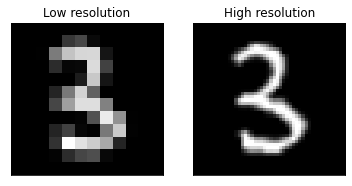

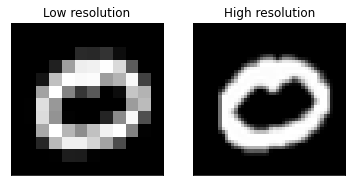

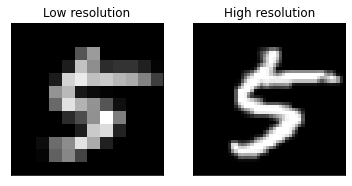

In [5]:
image_dataset.plot_sample()
image_dataset.plot_sample()
image_dataset.plot_sample()

## GAN model

### Generator

In [6]:
class ConvBlock(nn.Module):

    def __init__(self, n_channels):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(n_channels,n_channels,3,padding=1,bias=False),
            nn.BatchNorm2d(n_channels, 0.8),
            nn.PReLU(),
            nn.Conv2d(n_channels,n_channels,3,padding=1,bias=False),
            nn.BatchNorm2d(n_channels, 0.8)
        )

    def forward(self, x):
        return x+self.conv(x)

In [7]:
class PixelShuffleBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.ps_block = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,3,padding=1,bias=False),
            nn.PixelShuffle(2),
            nn.PReLU()
        )

    def forward(self, x):
        return self.ps_block(x)

In [8]:
class Generator(nn.Module):

    def __init__(self, 
                 conv_channels=64, 
                 n_res_blocks=3,
                 n_ps_blocks=2):
        super().__init__()
        
        # Initial conv
        self.init_conv = nn.Sequential(
            nn.Conv2d(1,conv_channels,3,padding=1,bias=False),
            nn.PReLU()
        )

        # Residual blocks
        self.res = nn.Sequential(
            *[ConvBlock(conv_channels) for _ in range(n_res_blocks)]
        )

        # Conv after resnet
        self.res_end_conv = nn.Sequential(
            nn.Conv2d(conv_channels,conv_channels,3,padding=1,bias=False),
            nn.BatchNorm2d(conv_channels)
        )

        # Pixel shuffle blocks
        self.ps_blocks = nn.Sequential(
            *[PixelShuffleBlock(conv_channels,256) for _ in range(n_ps_blocks)]
        )

        # Final conv to get channels right
        self.out_conv = nn.Conv2d(conv_channels,1,3,padding=1,bias=False)

    def forward(self, h):
        
        # Residual blocks
        h1 = self.init_conv(h)
        h = self.res(h1)
        h = self.res_end_conv(h)
        h = torch.add(h, h1)

        # Pixel shuffle blocks
        h = self.ps_blocks(h)

        # Output conv
        h = self.out_conv(h)

        return h

### Discriminator

In [9]:
class DiscConvBlock(nn.Module):
    def __init__(self, 
                 in_channels, 
                 out_channels,
                 stride):
        super().__init__()

        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,3,
                      stride=stride,padding=1,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU()
        )

    def forward(self, x):
        return self.conv_block(x)

In [10]:
class Discriminator(nn.Module):

    def __init__(self,
                 conv_channels=64,
                 conv_in_channels=[64,64,128],
                 conv_out_channels=[64,128,128],
                 stride=[2,1,2]):
        
        super().__init__()

        self.init_conv = nn.Sequential(
            nn.Conv2d(1,conv_channels,3,padding=1,bias=False),
            nn.LeakyReLU()
        )

        self.conv_blocks = nn.Sequential(*[DiscConvBlock(*i) for 
                                          i in zip(conv_in_channels,
                                              conv_out_channels,
                                              stride)]
                                         )

        self.out_block = nn.Sequential(
            nn.Linear(18432, 1024),
            nn.LeakyReLU(),
            nn.Linear(1024, 1),
        )

    def forward(self, x):

        x = self.init_conv(x)
        x = self.conv_blocks(x)
        x = x.view(x.shape[0],-1)
        x = self.out_block(x)

        sig = nn.Sigmoid()
        x = sig(x/100)

        return x

## Trainer

In [17]:
class Trainer():
    
    def __init__(self,
                 n_epochs,
                 disc,
                 gen,
                 gen_optim,
                 disc_optim,
                 train_data,
                 val_data):
        # Training 
        self.n_epochs = n_epochs

        # Model
        self.gen = gen
        self.disc = disc
        self.gen_optimizer = gen_optim
        self.disc_optimizer = disc_optim

        # Data
        self.train_data = train_data
        self.val_data = val_data

        # Losses
        self.l1 = nn.L1Loss()
        self.mse = nn.MSELoss()

    def get_disc_loss(self, pred_real, pred_fake):

        ground_truth_real = torch.ones_like(pred_real)
        ground_truth_fake = torch.zeros_like(pred_fake)

        disc_loss_real = self.mse(pred_real, ground_truth_real)
        disc_loss_fake = self.mse(pred_fake, ground_truth_fake)

        return disc_loss_fake+disc_loss_real

    def get_gen_loss(self, disc_fake, real_image, gen_image):

        ground_truth = torch.ones_like(disc_fake)
        adv_loss = self.mse(disc_fake, ground_truth)
        con_loss = self.l1(real_image, gen_image)

        return adv_loss*1e-3 + con_loss

    def plot_sample(self, low_res, high_res, gen_out, n_samples):

        for i in range(n_samples):
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
            ax1.imshow(high_res.cpu().numpy()[i,0,...], cmap="gray")
            ax1.set_title("Ground truth")
            ax2.imshow(low_res.cpu().numpy()[i,0,...], cmap="gray")
            ax2.set_title("Low-res")
            ax3.imshow(gen_out.cpu().detach().numpy()[i,0,...], cmap="gray")
            ax3.set_title("Generated")

            for i in [ax1, ax2]:
                i.xaxis.set_visible(False)
                i.yaxis.set_visible(False) 

            plt.show()

    def plot_losses(self, disc_loss_list, gen_loss_list):
        fig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.plot(np.array(disc_loss_list))
        ax1.set_title("Discriminator loss")
        ax2.plot(np.array(gen_loss_list))
        ax2.set_title("Generator loss")

        plt.show()
   
    def train(self):
        
        disc_loss_list = []
        gen_loss_list = []
        
        for epoch in range(self.n_epochs):

            for low_res, high_res in tqdm(self.train_data):

                # Generator
                self.gen_optimizer.zero_grad()
                gen_out = self.gen(low_res)
                disc_fake = self.disc(gen_out)

                gen_loss = self.get_gen_loss(disc_fake, high_res, gen_out)
                gen_loss.backward(retain_graph=True)

                # Discriminator
                self.disc_optimizer.zero_grad()
                disc_real = self.disc(high_res)

                disc_loss = self.get_disc_loss(disc_real, disc_fake)
                disc_loss.backward()
                self.gen_optimizer.step()
                self.disc_optimizer.step()
                
                disc_loss_list.append(disc_loss.item())
                gen_loss_list.append(gen_loss.item())
                #print("Disc loss = {}, Gen loss = {}".format(disc_loss.item(), gen_loss.item()))

            print("Discriminator loss is {}, generator loss is {}".format(
                np.mean(disc_loss_list), np.mean(gen_loss_list)
            ))

            # Plot losses
            self.plot_losses(disc_loss_list, gen_loss_list)

            # Plot a sample
            self.plot_sample(low_res, high_res, gen_out, n_samples=3)



## Train model

In [12]:
# Training and validation datasets

train = MNISTDataset(train=True)
train_data = torch.utils.data.DataLoader(train,
                                         shuffle = True,
                                         batch_size = 128)

val = MNISTDataset(train=False)
val_data = torch.utils.data.DataLoader(val,
                                       shuffle = True,
                                       batch_size = 128)


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


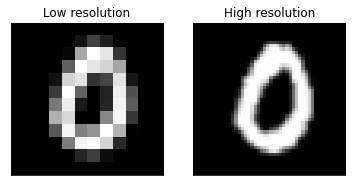

In [13]:
# Plot a sample
val.plot_sample()

In [14]:
# Define generator and discriminator
gen = Generator()
gen.to(device)
disc = Discriminator()
disc.to(device)
gen_optim = optim.Adam(gen.parameters(),lr=0.001)
disc_optim = optim.Adam(disc.parameters(),lr=0.001)

In [15]:
# Training class
trainer = Trainer(100,
                 disc,
                 gen,
                 gen_optim,
                 disc_optim,
                 train_data,
                 val_data)

100%|██████████| 469/469 [00:48<00:00,  9.58it/s]


Discriminator loss is 0.31084837739002896, generator loss is 0.09309456212275317


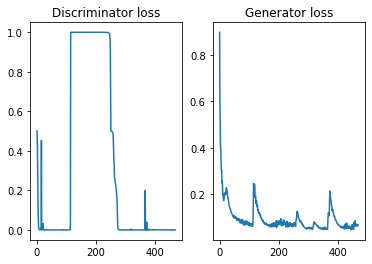

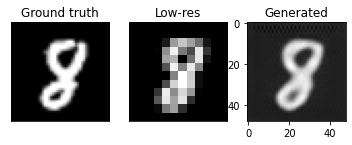

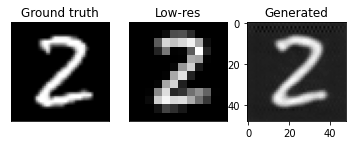

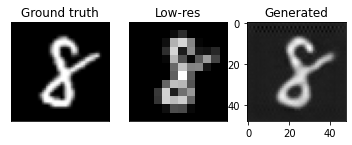

100%|██████████| 469/469 [00:50<00:00,  9.30it/s]


Discriminator loss is 0.15544057485341134, generator loss is 0.07172697689185646


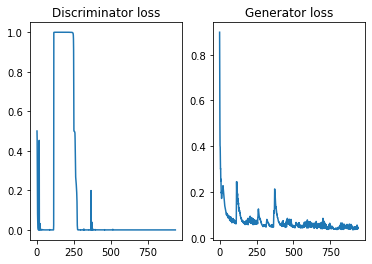

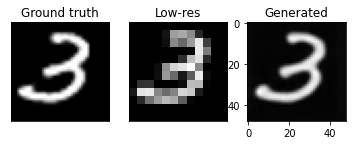

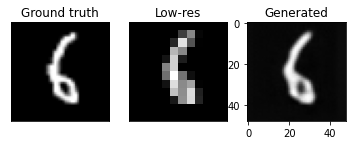

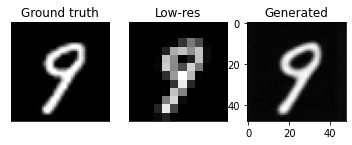

100%|██████████| 469/469 [00:49<00:00,  9.44it/s]


Discriminator loss is 0.103629916349175, generator loss is 0.0613915715909377


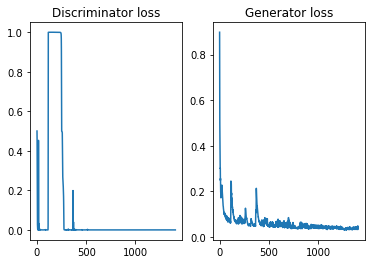

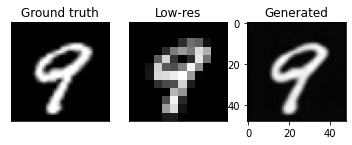

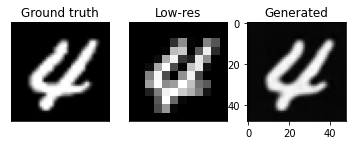

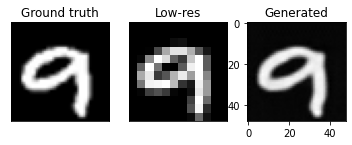

100%|██████████| 469/469 [00:50<00:00,  9.32it/s]


Discriminator loss is 0.07772903606424912, generator loss is 0.055441209563870296


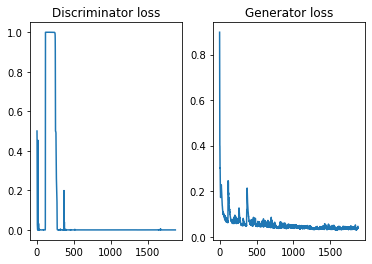

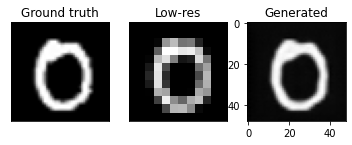

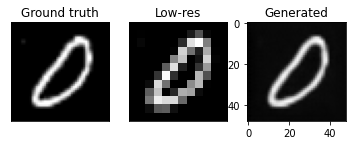

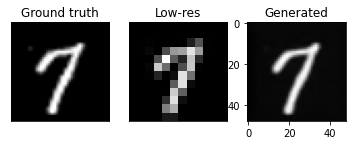

100%|██████████| 469/469 [00:50<00:00,  9.33it/s]


Discriminator loss is 0.06218385546270403, generator loss is 0.05126475013776629


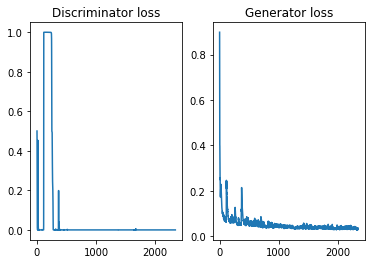

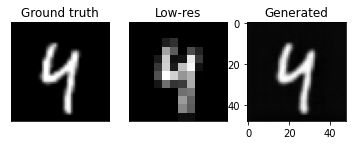

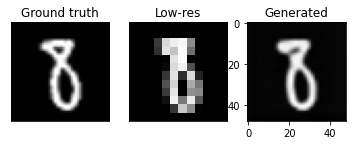

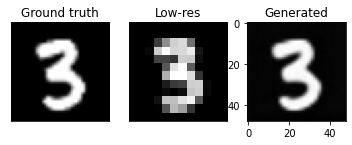

100%|██████████| 469/469 [00:51<00:00,  9.14it/s]


Discriminator loss is 0.052192681055790224, generator loss is 0.05285758086742983


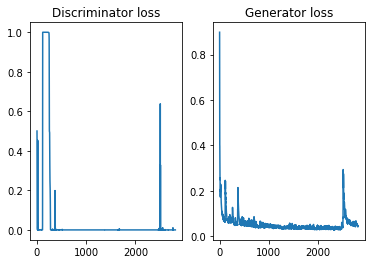

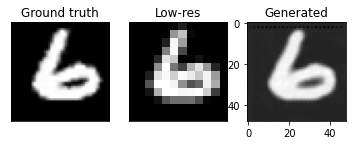

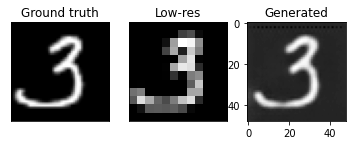

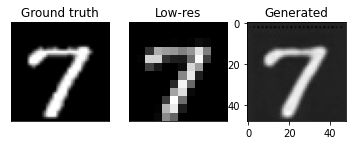

100%|██████████| 469/469 [00:50<00:00,  9.22it/s]


Discriminator loss is 0.044742015479873956, generator loss is 0.05129058100566826


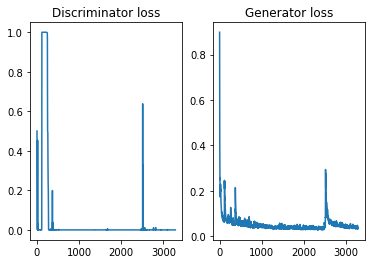

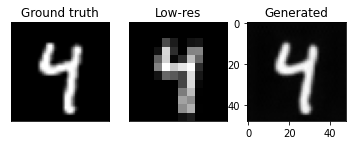

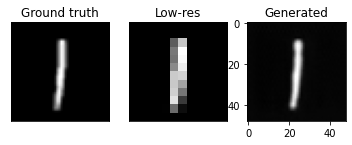

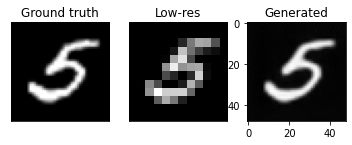

100%|██████████| 469/469 [00:51<00:00,  9.14it/s]


Discriminator loss is 0.03914960143938076, generator loss is 0.04940998020903595


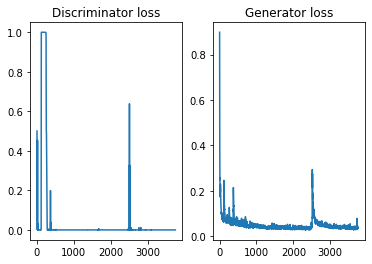

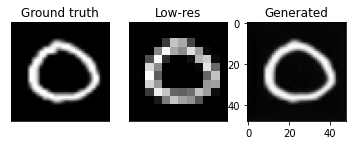

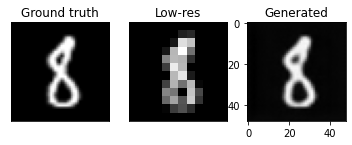

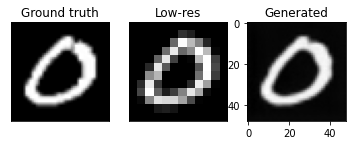

100%|██████████| 469/469 [00:50<00:00,  9.26it/s]


Discriminator loss is 0.03481431286386256, generator loss is 0.04774738225606671


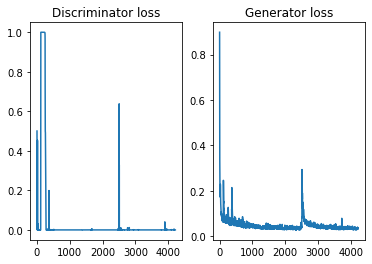

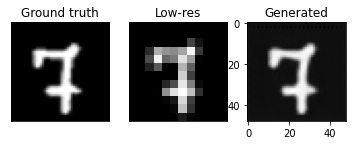

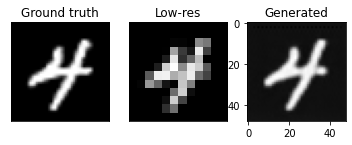

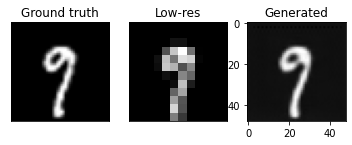

100%|██████████| 469/469 [00:50<00:00,  9.24it/s]


Discriminator loss is 0.0313330045823141, generator loss is 0.046168632684215935


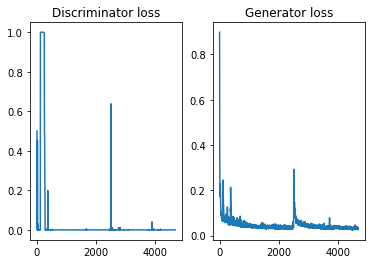

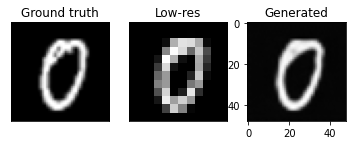

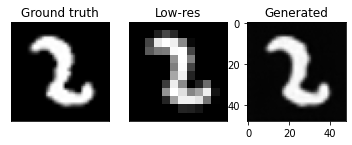

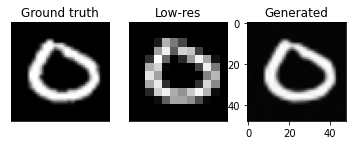

100%|██████████| 469/469 [00:51<00:00,  9.18it/s]


Discriminator loss is 0.028742567726676414, generator loss is 0.04638720240373902


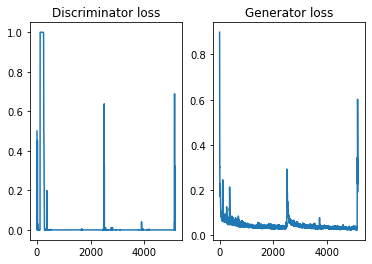

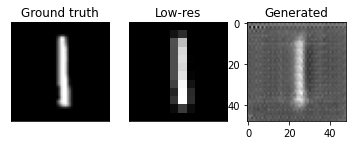

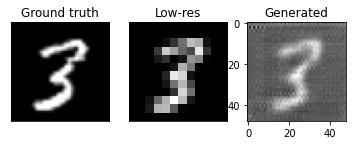

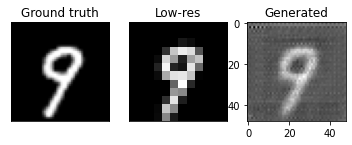

100%|██████████| 469/469 [00:51<00:00,  9.19it/s]


Discriminator loss is 0.026351414988176506, generator loss is 0.04782389920580849


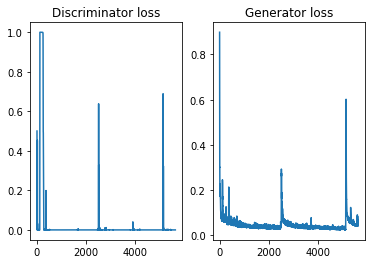

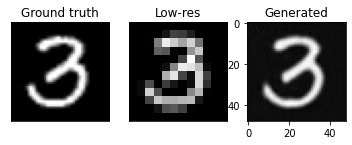

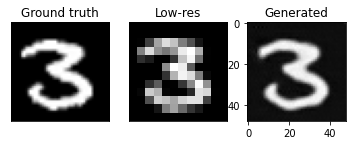

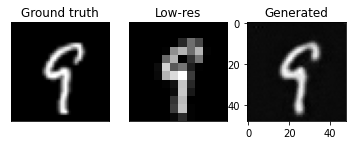

100%|██████████| 469/469 [00:51<00:00,  9.17it/s]


Discriminator loss is 0.024326298084105028, generator loss is 0.047240823536637146


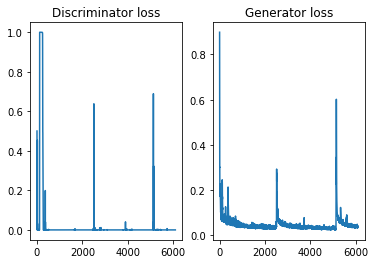

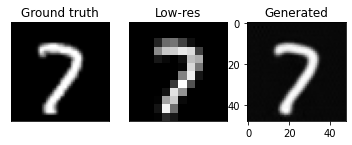

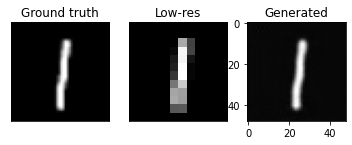

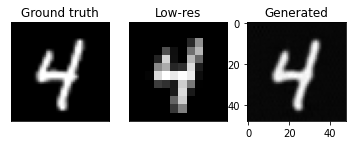

100%|██████████| 469/469 [00:51<00:00,  9.19it/s]


Discriminator loss is 0.022590009533452665, generator loss is 0.04650880264483127


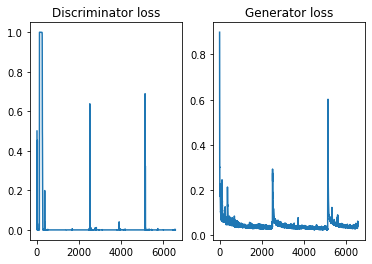

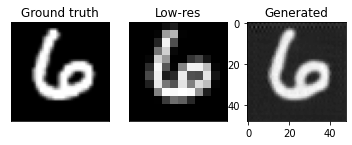

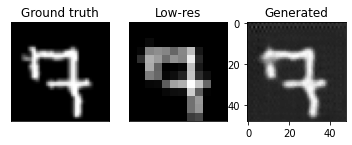

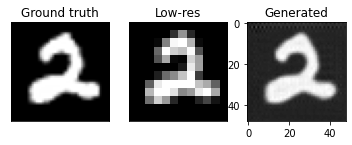

100%|██████████| 469/469 [00:50<00:00,  9.21it/s]


Discriminator loss is 0.021084570311947968, generator loss is 0.04578949093273242


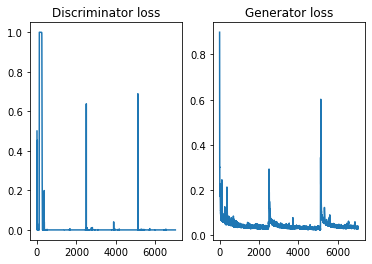

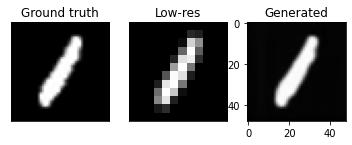

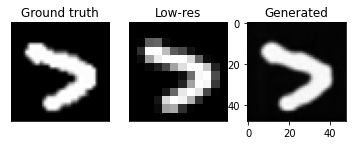

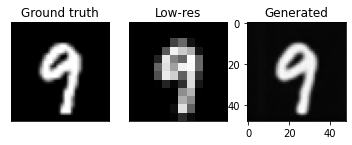

100%|██████████| 469/469 [00:51<00:00,  9.19it/s]


Discriminator loss is 0.019770026845265885, generator loss is 0.0452139339519482


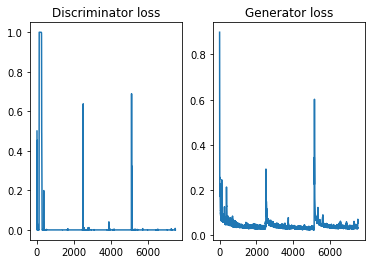

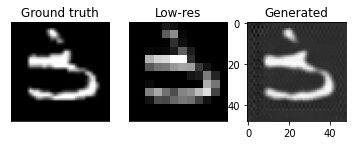

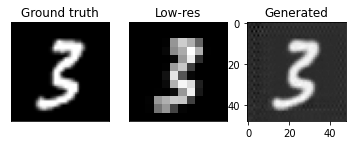

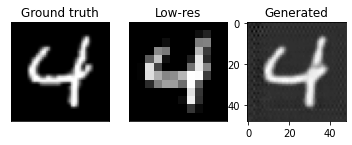

100%|██████████| 469/469 [00:50<00:00,  9.21it/s]


Discriminator loss is 0.018610462455827995, generator loss is 0.04504319193853453


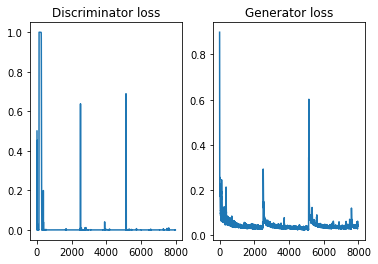

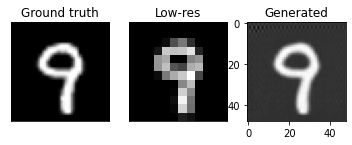

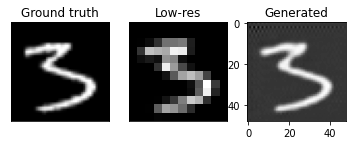

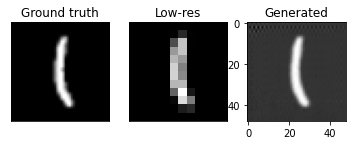

100%|██████████| 469/469 [00:51<00:00,  9.14it/s]


Discriminator loss is 0.017577863071362023, generator loss is 0.04461618776313362


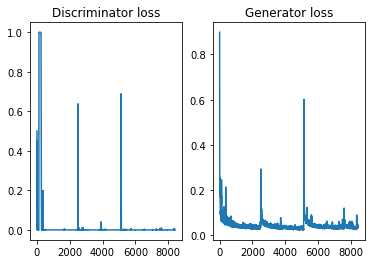

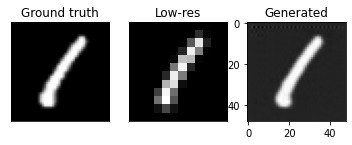

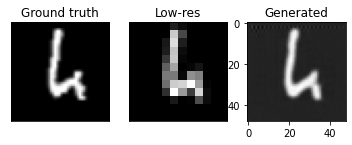

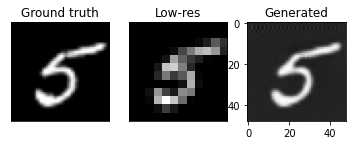

100%|██████████| 469/469 [00:51<00:00,  9.13it/s]


Discriminator loss is 0.01665362512495591, generator loss is 0.043914335601858694


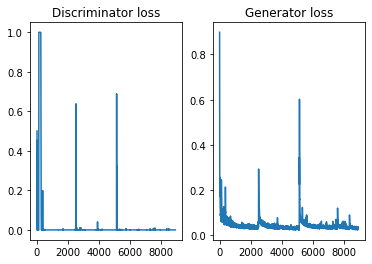

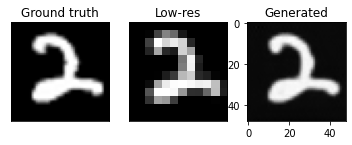

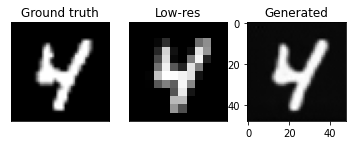

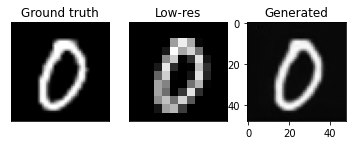

100%|██████████| 469/469 [00:51<00:00,  9.11it/s]


Discriminator loss is 0.01582123391803209, generator loss is 0.043267978649181346


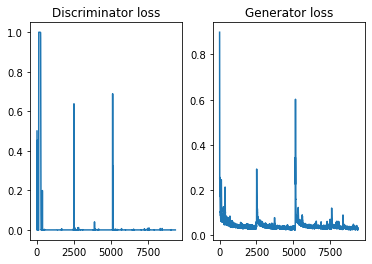

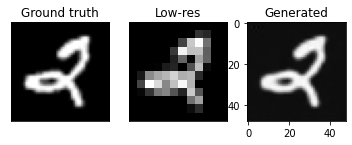

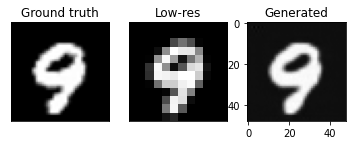

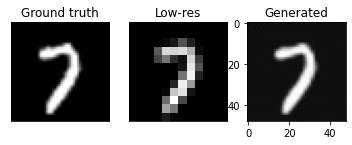

100%|██████████| 469/469 [00:51<00:00,  9.13it/s]


Discriminator loss is 0.015069290178683983, generator loss is 0.042706442658145216


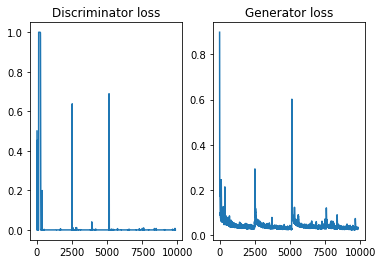

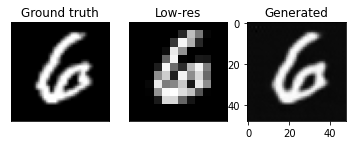

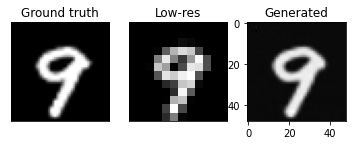

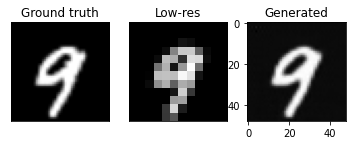

100%|██████████| 469/469 [00:51<00:00,  9.05it/s]


Discriminator loss is 0.014385261505498256, generator loss is 0.04217888530070097


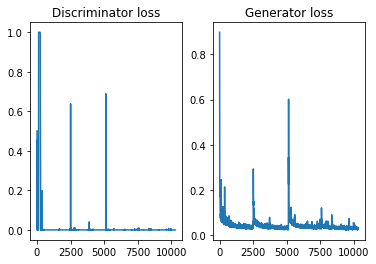

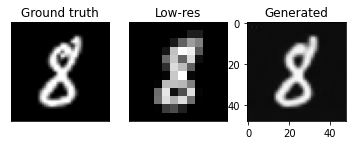

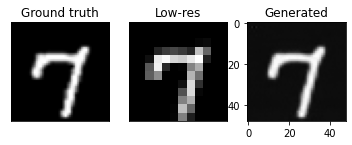

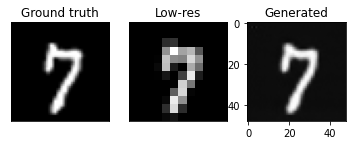

100%|██████████| 469/469 [00:51<00:00,  9.09it/s]


Discriminator loss is 0.013759832135407291, generator loss is 0.041561766535622525


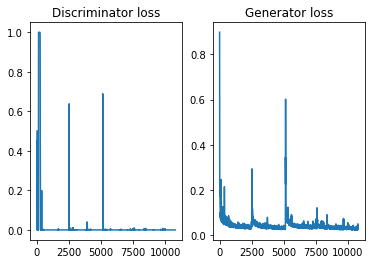

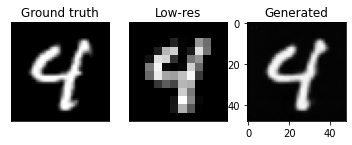

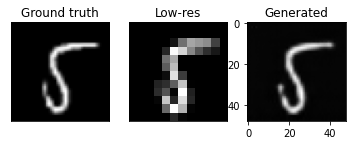

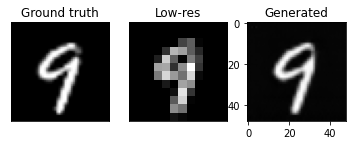

100%|██████████| 469/469 [00:51<00:00,  9.09it/s]


Discriminator loss is 0.013189180875373305, generator loss is 0.04112222564605931


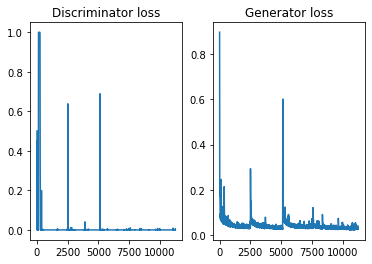

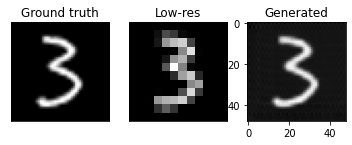

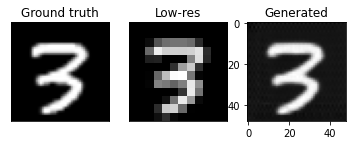

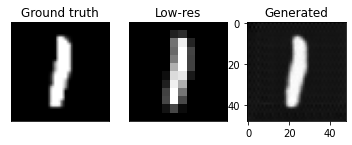

100%|██████████| 469/469 [00:51<00:00,  9.10it/s]


Discriminator loss is 0.012662931280635845, generator loss is 0.040621157428507866


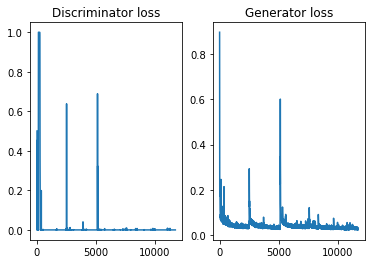

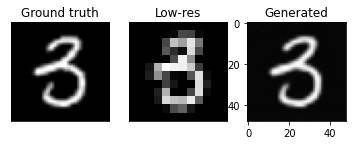

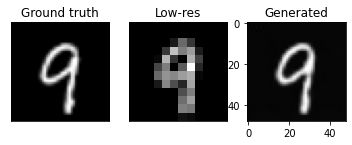

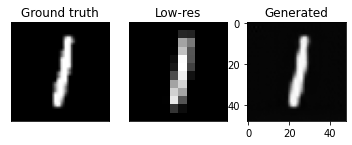

100%|██████████| 469/469 [00:51<00:00,  9.15it/s]


Discriminator loss is 0.012175914707750686, generator loss is 0.04009081388256829


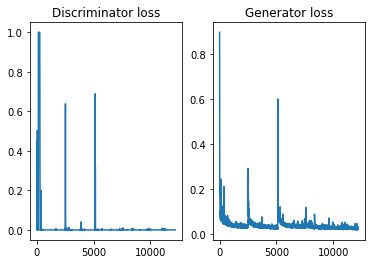

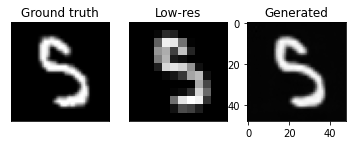

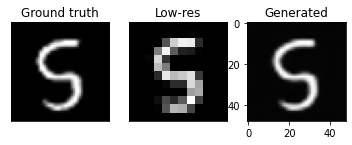

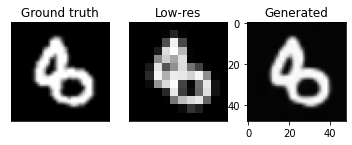

100%|██████████| 469/469 [00:51<00:00,  9.19it/s]


Discriminator loss is 0.011725926424665224, generator loss is 0.039612567036064854


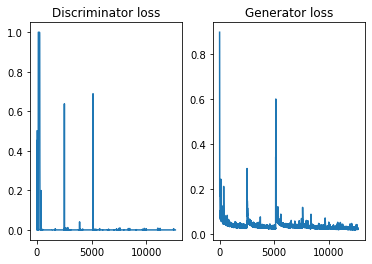

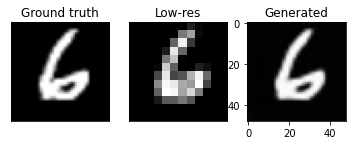

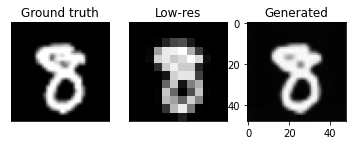

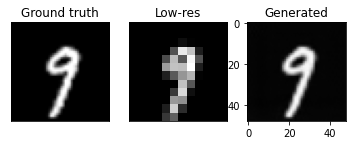

100%|██████████| 469/469 [00:51<00:00,  9.16it/s]


Discriminator loss is 0.011307196260482186, generator loss is 0.039111921591545216


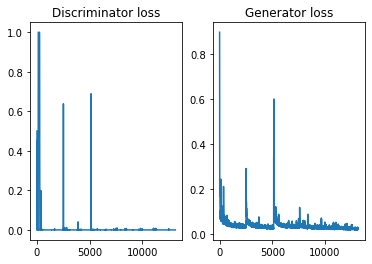

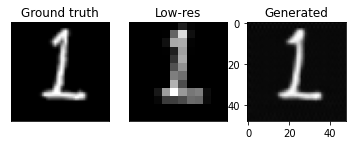

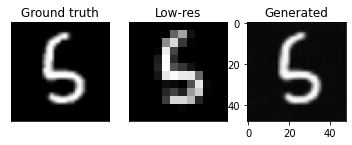

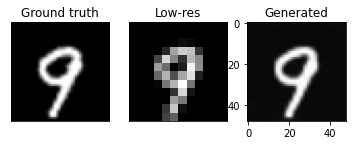

100%|██████████| 469/469 [00:51<00:00,  9.18it/s]


Discriminator loss is 0.010917825994349364, generator loss is 0.03864082944259715


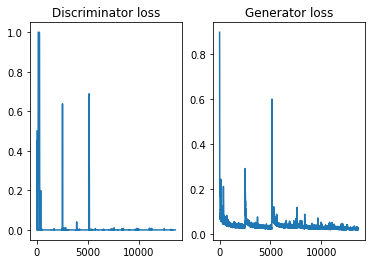

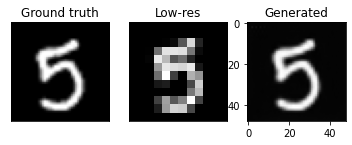

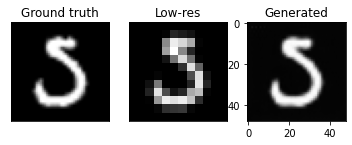

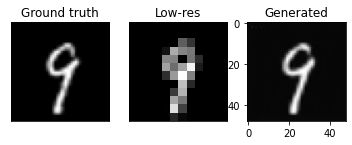

100%|██████████| 469/469 [00:51<00:00,  9.18it/s]


Discriminator loss is 0.010553929398556618, generator loss is 0.03821550736345441


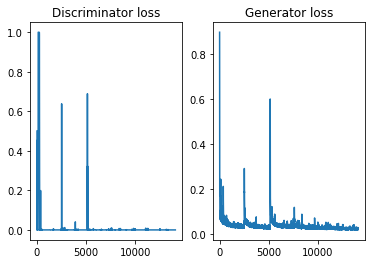

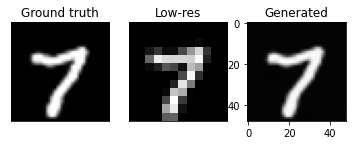

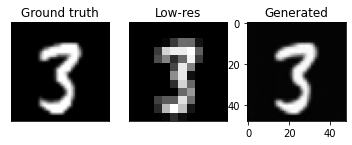

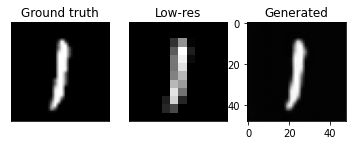

100%|██████████| 469/469 [00:51<00:00,  9.13it/s]


Discriminator loss is 0.010213559982490936, generator loss is 0.037796434546323164


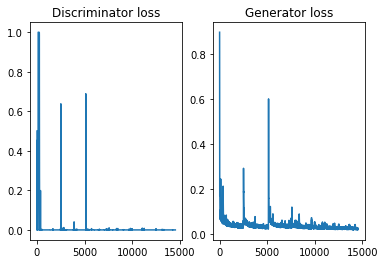

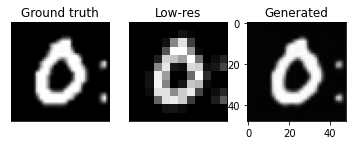

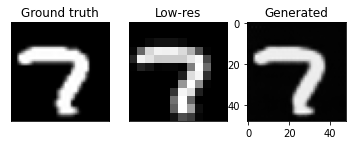

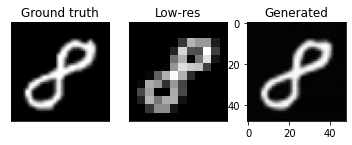

100%|██████████| 469/469 [00:51<00:00,  9.10it/s]


Discriminator loss is 0.00994836445085205, generator loss is 0.03800487156504634


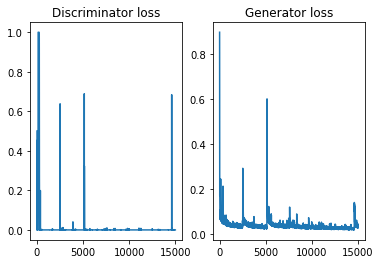

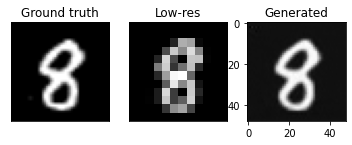

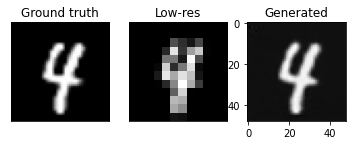

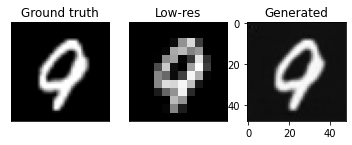

100%|██████████| 469/469 [00:51<00:00,  9.11it/s]


Discriminator loss is 0.009647045593103332, generator loss is 0.03774102473878337


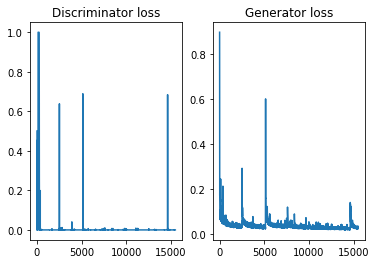

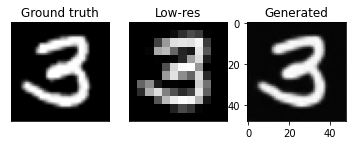

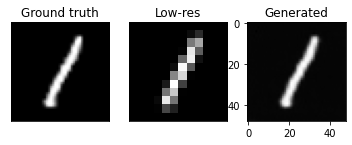

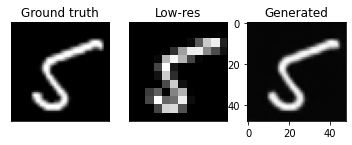

100%|██████████| 469/469 [00:51<00:00,  9.04it/s]


Discriminator loss is 0.009363839953835577, generator loss is 0.03750431087350705


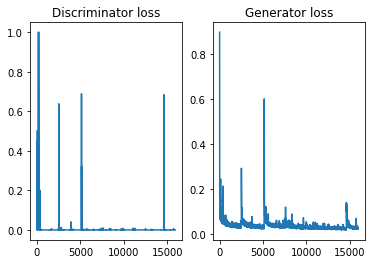

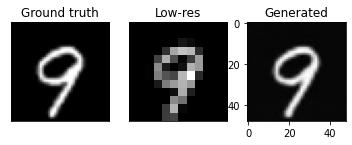

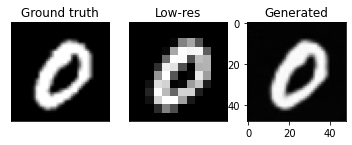

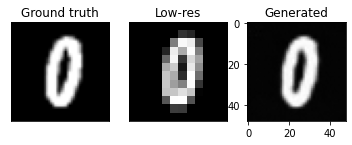

100%|██████████| 469/469 [00:51<00:00,  9.08it/s]


Discriminator loss is 0.009096634430339012, generator loss is 0.037250043982268284


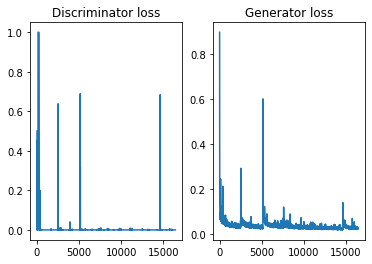

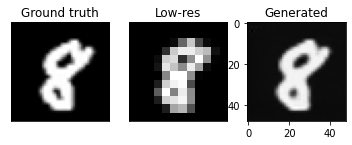

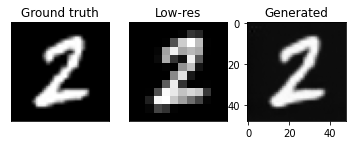

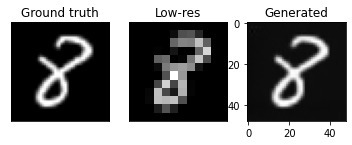

100%|██████████| 469/469 [00:51<00:00,  9.11it/s]


Discriminator loss is 0.008844315301710164, generator loss is 0.037052189122185594


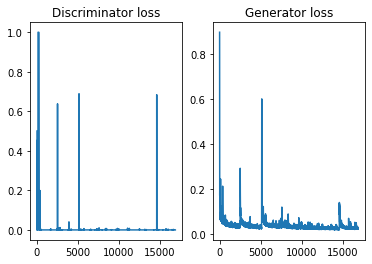

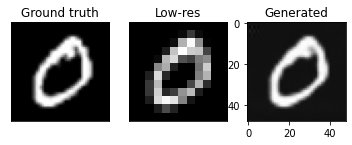

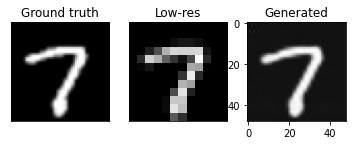

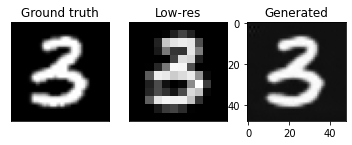

100%|██████████| 469/469 [00:51<00:00,  9.10it/s]


Discriminator loss is 0.008605283174963325, generator loss is 0.03674025239917426


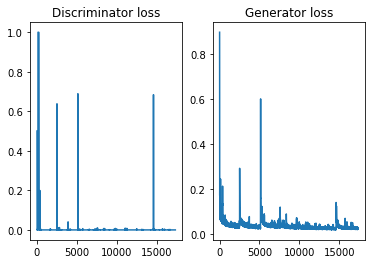

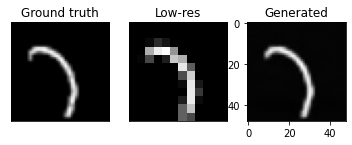

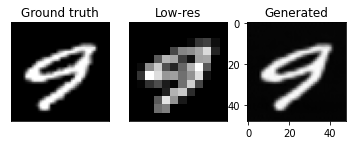

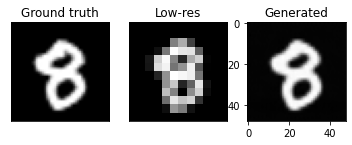

100%|██████████| 469/469 [00:51<00:00,  9.05it/s]


Discriminator loss is 0.008379572510236317, generator loss is 0.03655278710007748


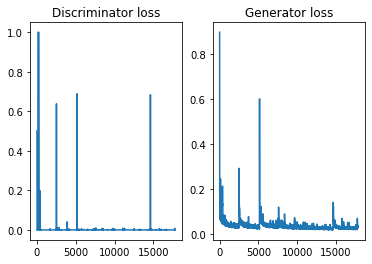

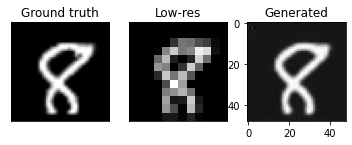

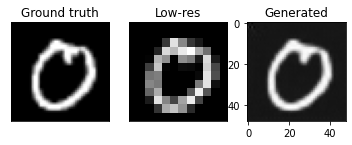

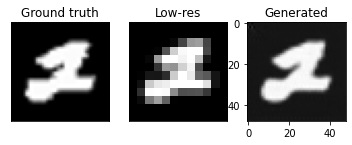

100%|██████████| 469/469 [00:51<00:00,  9.05it/s]


Discriminator loss is 0.008164933388209684, generator loss is 0.03634076628905904


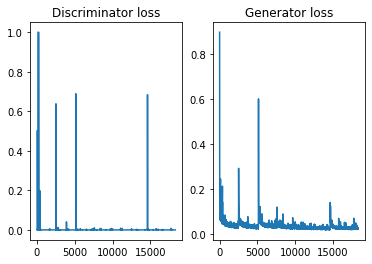

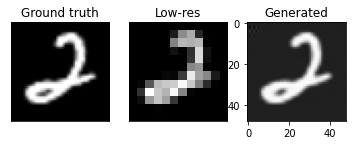

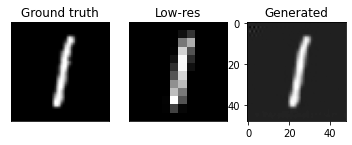

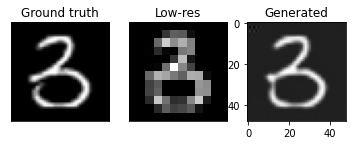

100%|██████████| 469/469 [00:52<00:00,  9.00it/s]


Discriminator loss is 0.007960810292509071, generator loss is 0.03612627879724399


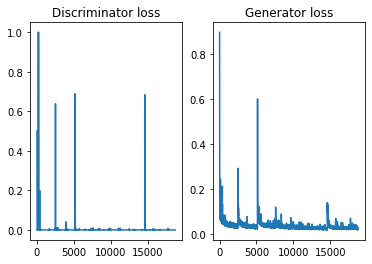

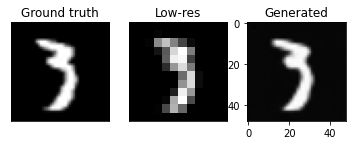

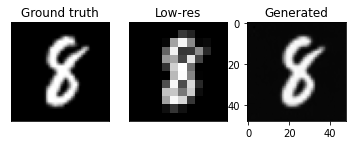

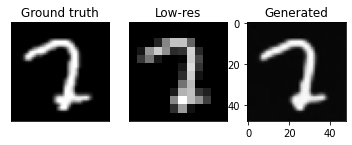

100%|██████████| 469/469 [00:52<00:00,  8.99it/s]


Discriminator loss is 0.007767500375244745, generator loss is 0.03584801112695652


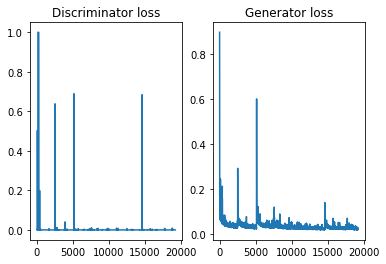

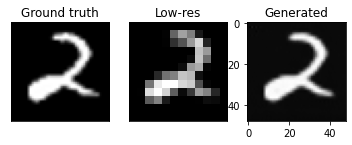

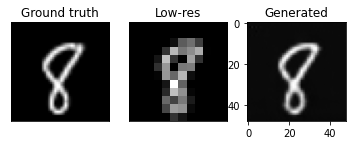

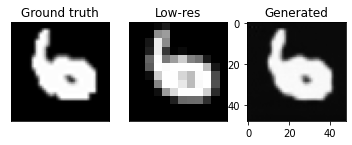

100%|██████████| 469/469 [00:51<00:00,  9.06it/s]


Discriminator loss is 0.007582958599359135, generator loss is 0.035580254946229684


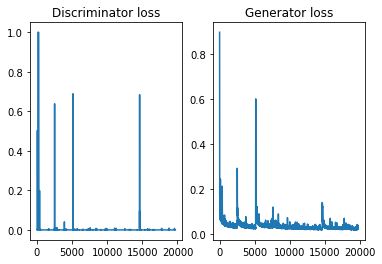

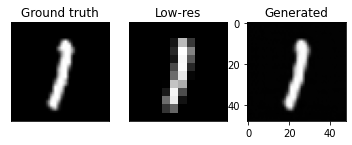

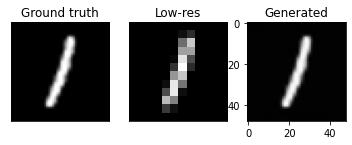

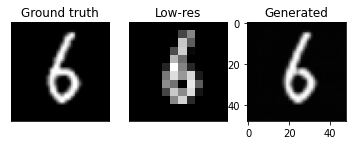

100%|██████████| 469/469 [00:51<00:00,  9.03it/s]


Discriminator loss is 0.007408844456743659, generator loss is 0.03540391025145484


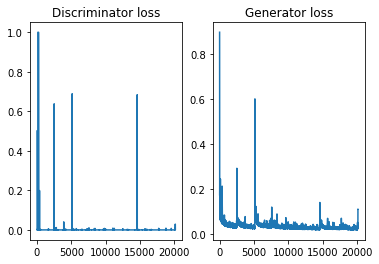

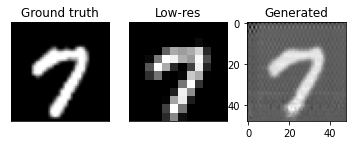

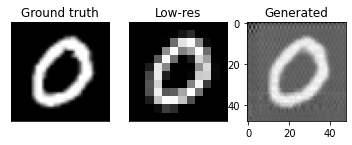

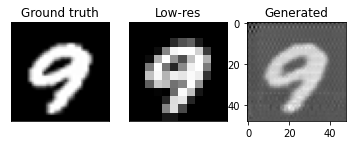

100%|██████████| 469/469 [00:52<00:00,  9.00it/s]


Discriminator loss is 0.007246613915664783, generator loss is 0.03595644066667711


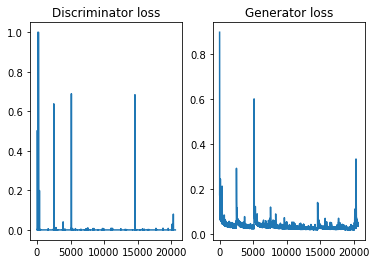

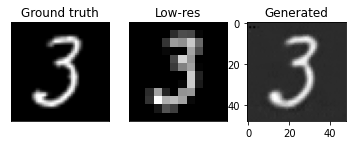

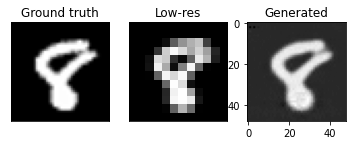

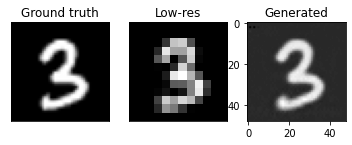

100%|██████████| 469/469 [00:51<00:00,  9.08it/s]


Discriminator loss is 0.007085589350498966, generator loss is 0.03595997232178593


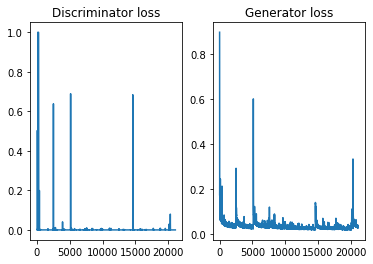

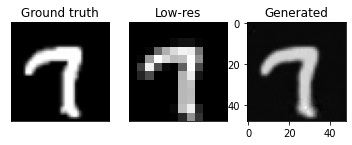

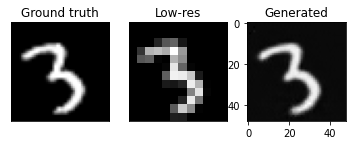

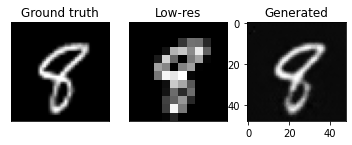

100%|██████████| 469/469 [00:52<00:00,  8.97it/s]


Discriminator loss is 0.006950529131095689, generator loss is 0.0378839631402687


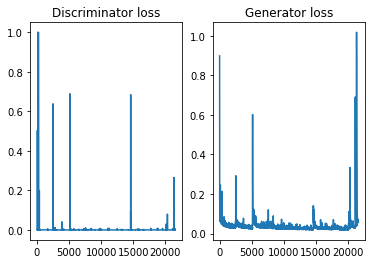

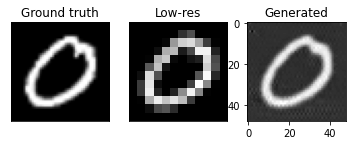

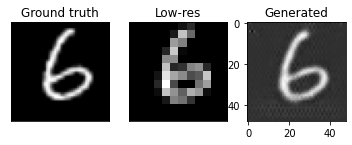

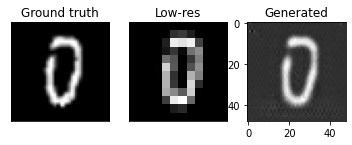

100%|██████████| 469/469 [00:51<00:00,  9.10it/s]


Discriminator loss is 0.0068039093561581025, generator loss is 0.039301936177053756


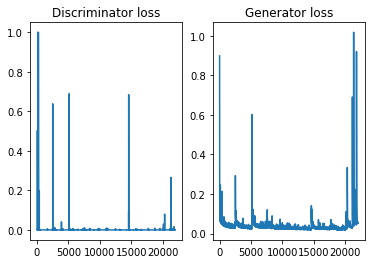

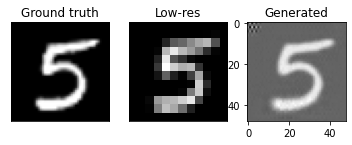

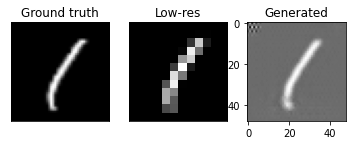

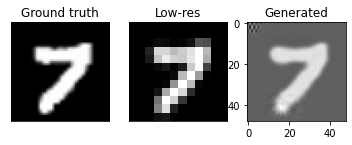

100%|██████████| 469/469 [00:51<00:00,  9.14it/s]


Discriminator loss is 0.00666216124457148, generator loss is 0.03938293005783288


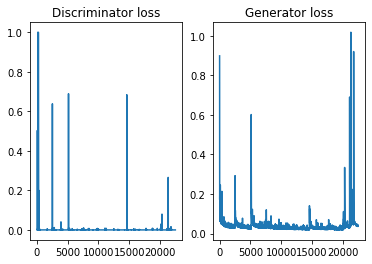

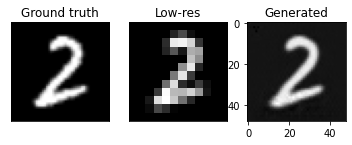

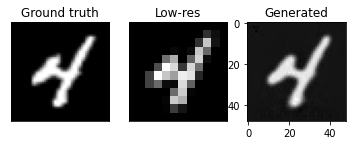

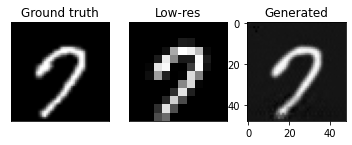

100%|██████████| 469/469 [00:51<00:00,  9.11it/s]


Discriminator loss is 0.006526398349014234, generator loss is 0.0396814639008373


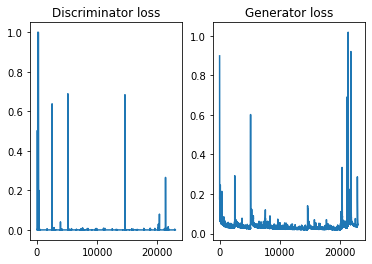

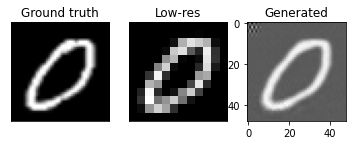

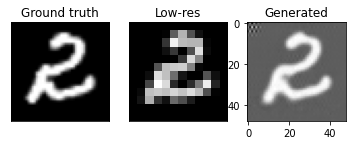

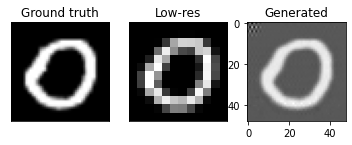

100%|██████████| 469/469 [00:51<00:00,  9.11it/s]


Discriminator loss is 0.00639587228638759, generator loss is 0.03963514351800306


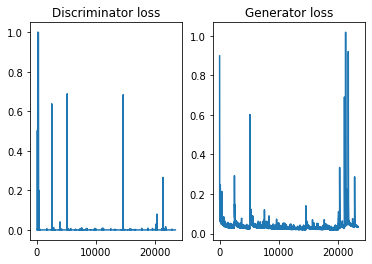

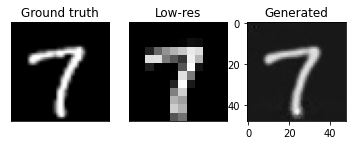

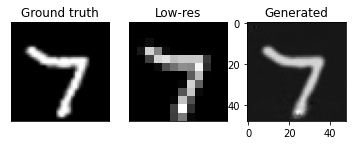

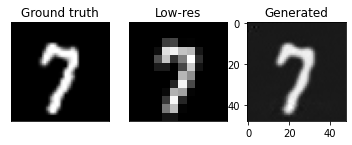

100%|██████████| 469/469 [00:51<00:00,  9.11it/s]


Discriminator loss is 0.006271048037259534, generator loss is 0.03963210369102497


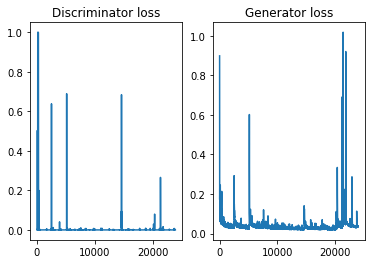

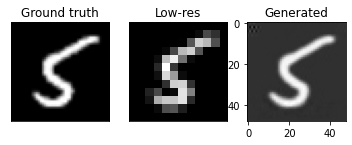

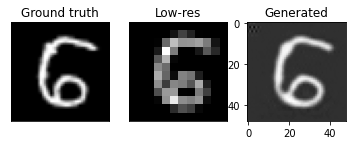

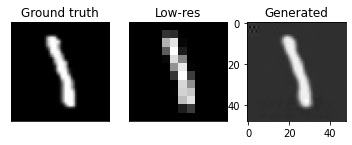

100%|██████████| 469/469 [00:51<00:00,  9.04it/s]


Discriminator loss is 0.006150488629396626, generator loss is 0.03967512134042225


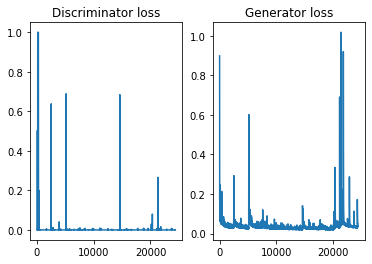

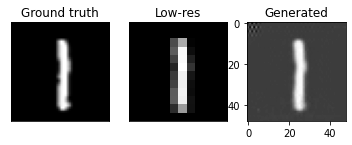

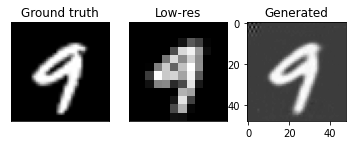

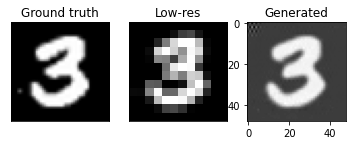

100%|██████████| 469/469 [00:51<00:00,  9.06it/s]


Discriminator loss is 0.006034442469086185, generator loss is 0.03952750836412823


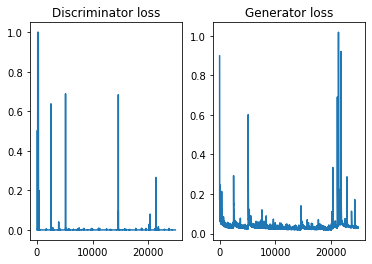

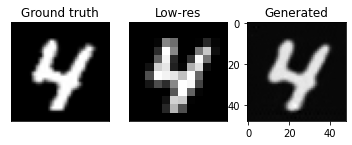

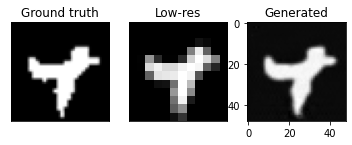

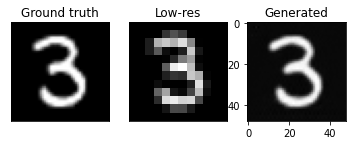

100%|██████████| 469/469 [00:51<00:00,  9.15it/s]


Discriminator loss is 0.005922969976746709, generator loss is 0.039376031600917336


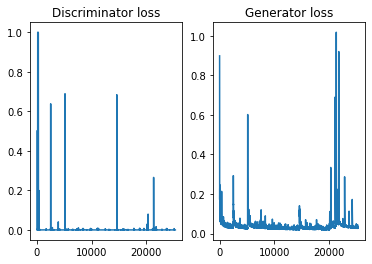

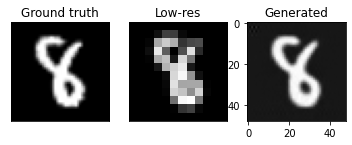

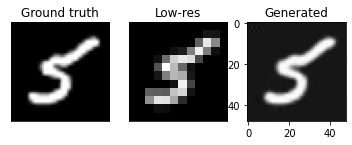

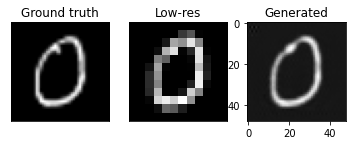

100%|██████████| 469/469 [00:51<00:00,  9.16it/s]


Discriminator loss is 0.005815917892121223, generator loss is 0.039334000149760906


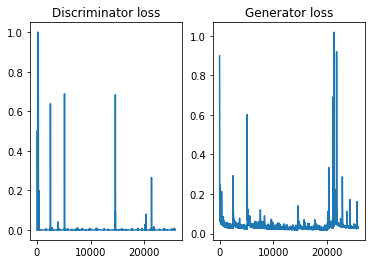

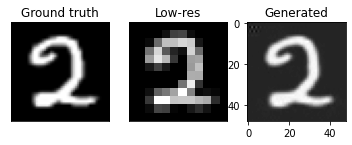

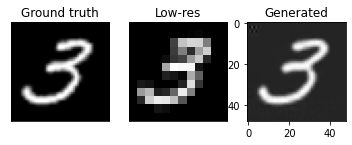

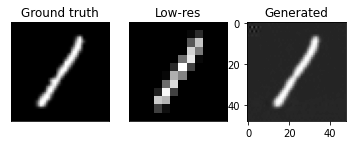

100%|██████████| 469/469 [00:51<00:00,  9.15it/s]


Discriminator loss is 0.005712861254132913, generator loss is 0.03925305595580333


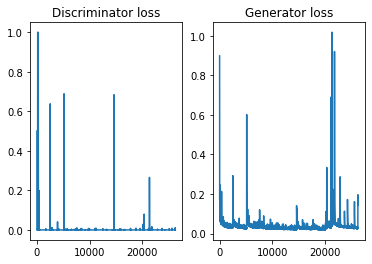

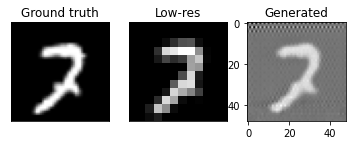

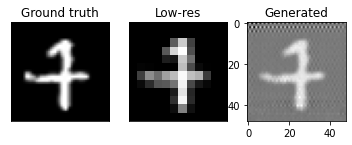

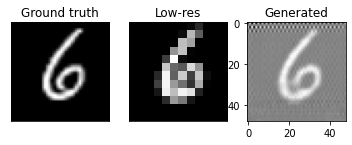

100%|██████████| 469/469 [00:51<00:00,  9.17it/s]


Discriminator loss is 0.0056126413512250055, generator loss is 0.03923005342598625


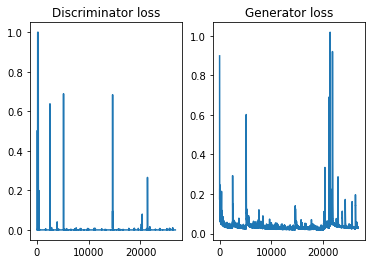

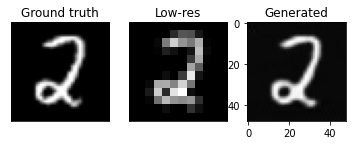

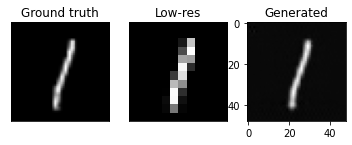

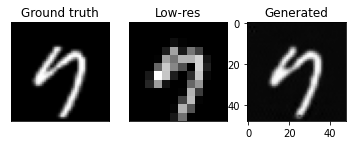

100%|██████████| 469/469 [00:50<00:00,  9.20it/s]


Discriminator loss is 0.005516105007051325, generator loss is 0.039404478631176874


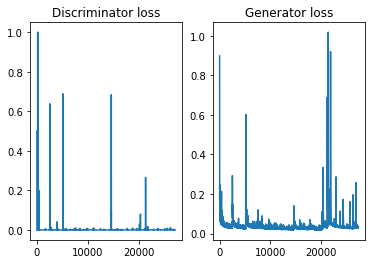

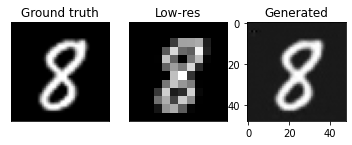

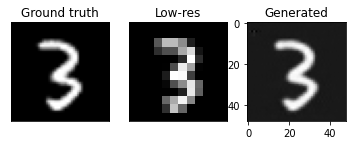

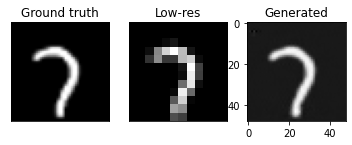

100%|██████████| 469/469 [00:50<00:00,  9.24it/s]


Discriminator loss is 0.0054226276854280765, generator loss is 0.0392403947869658


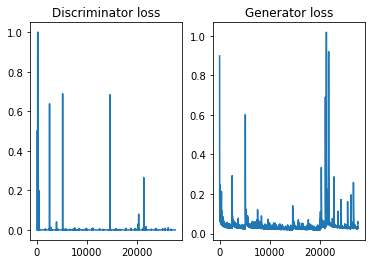

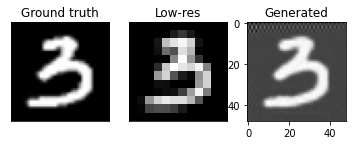

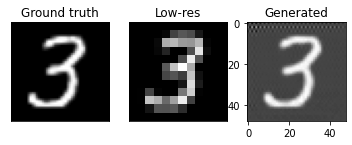

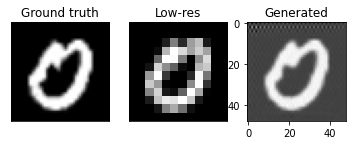

100%|██████████| 469/469 [00:50<00:00,  9.21it/s]


Discriminator loss is 0.005332457336201151, generator loss is 0.039271652133832206


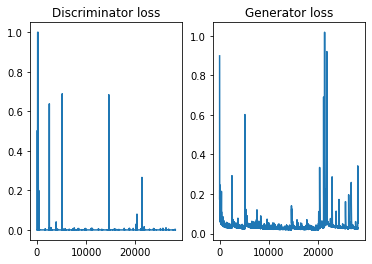

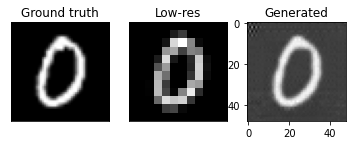

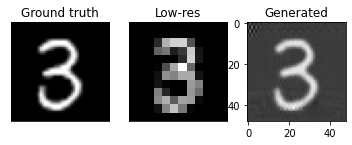

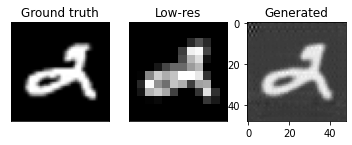

100%|██████████| 469/469 [00:51<00:00,  9.18it/s]


Discriminator loss is 0.005245574052527987, generator loss is 0.03919808055695463


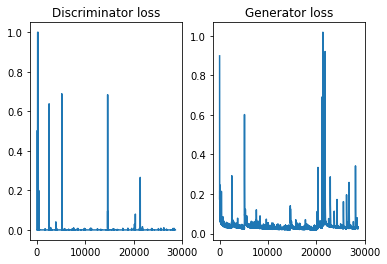

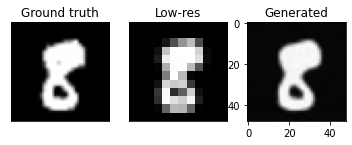

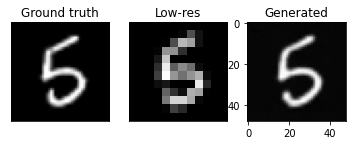

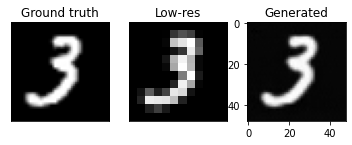

100%|██████████| 469/469 [00:51<00:00,  9.18it/s]


Discriminator loss is 0.00516099270948789, generator loss is 0.03910584832442421


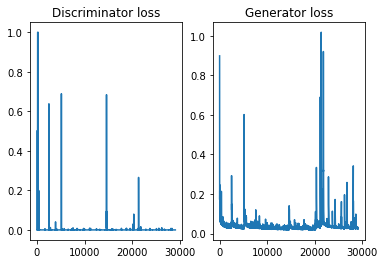

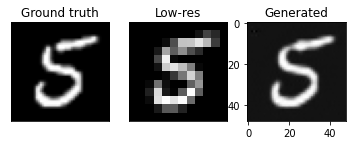

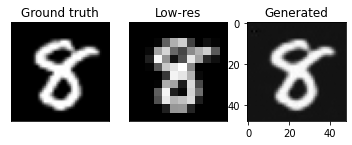

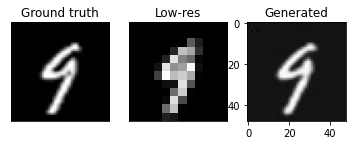

100%|██████████| 469/469 [00:51<00:00,  9.17it/s]


Discriminator loss is 0.0050795501973852205, generator loss is 0.03911860556660596


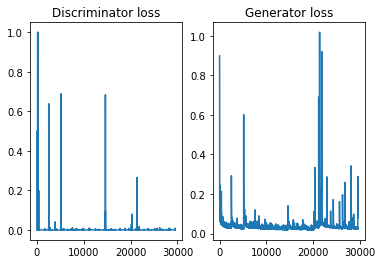

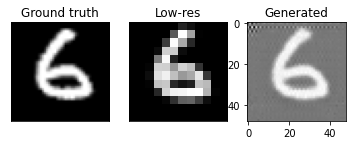

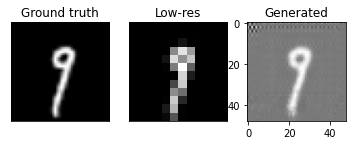

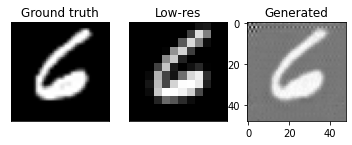

100%|██████████| 469/469 [00:51<00:00,  9.19it/s]


Discriminator loss is 0.005001038525136027, generator loss is 0.039108667706910356


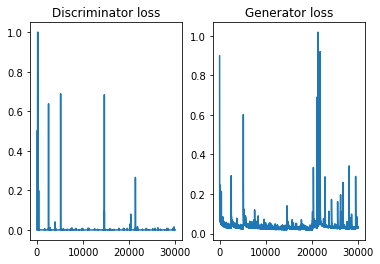

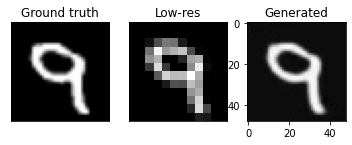

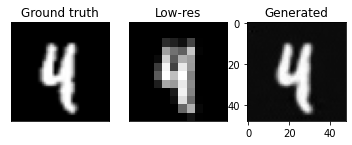

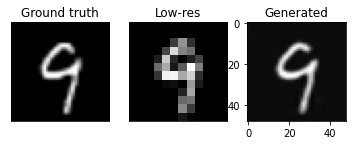

100%|██████████| 469/469 [00:51<00:00,  9.17it/s]


Discriminator loss is 0.004924920239179838, generator loss is 0.03928577120817449


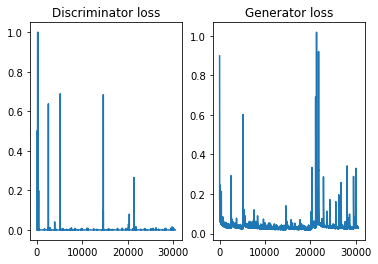

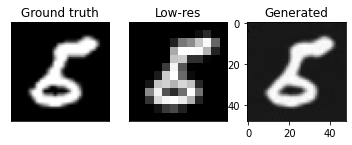

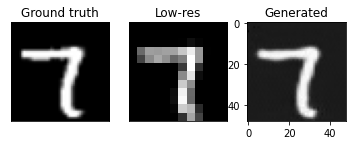

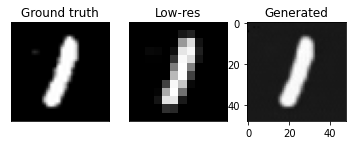

100%|██████████| 469/469 [00:51<00:00,  9.16it/s]


Discriminator loss is 0.004850792222179787, generator loss is 0.039216527633367526


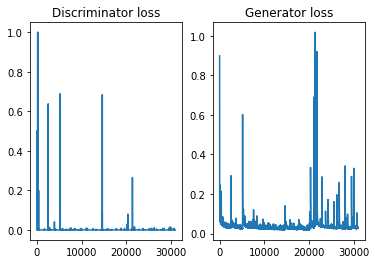

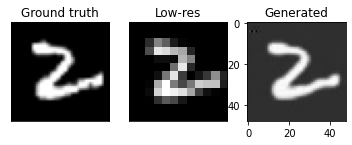

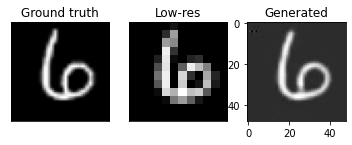

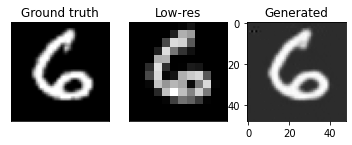

100%|██████████| 469/469 [00:51<00:00,  9.17it/s]


Discriminator loss is 0.004778640961886329, generator loss is 0.039030610217719905


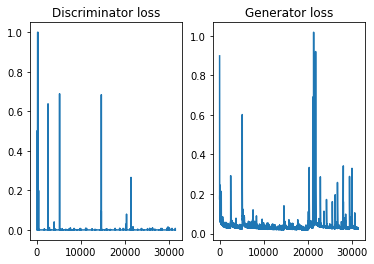

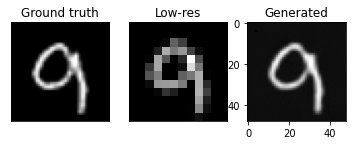

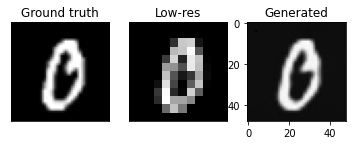

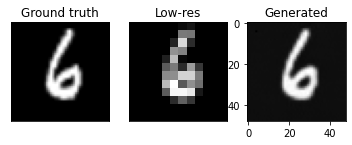

100%|██████████| 469/469 [00:51<00:00,  9.19it/s]


Discriminator loss is 0.0047087358833572054, generator loss is 0.039252942031307574


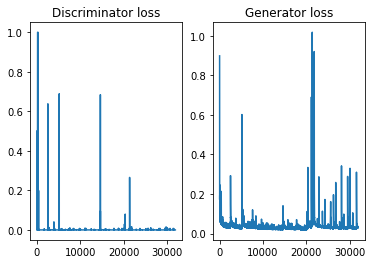

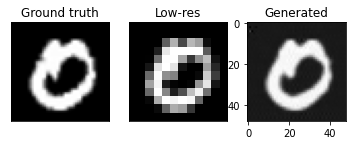

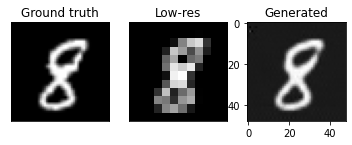

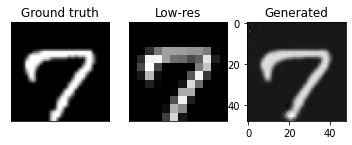

100%|██████████| 469/469 [00:51<00:00,  9.18it/s]


Discriminator loss is 0.004640799285390315, generator loss is 0.03923364092111321


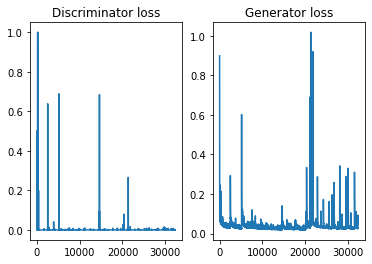

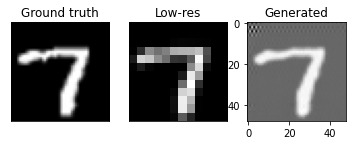

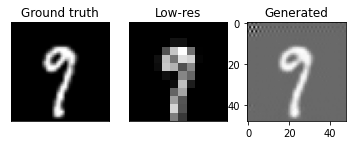

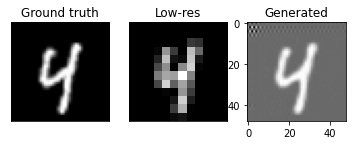

100%|██████████| 469/469 [00:50<00:00,  9.26it/s]


Discriminator loss is 0.004574502152741882, generator loss is 0.03910060450548157


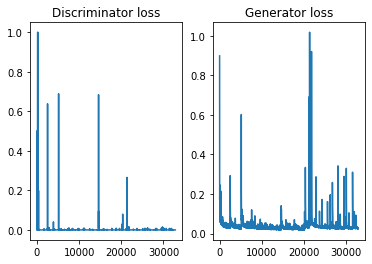

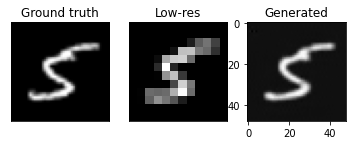

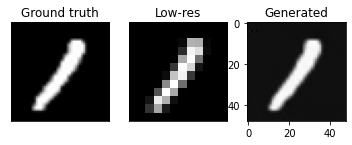

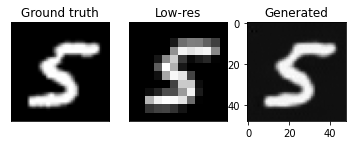

100%|██████████| 469/469 [00:50<00:00,  9.27it/s]


Discriminator loss is 0.00451085837252143, generator loss is 0.03915316013595754


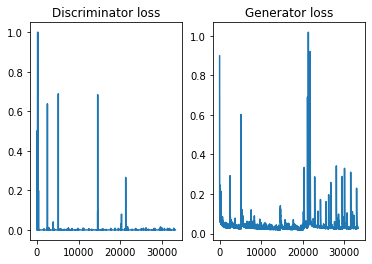

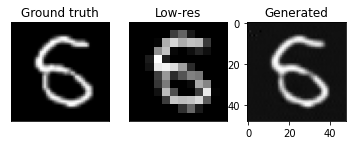

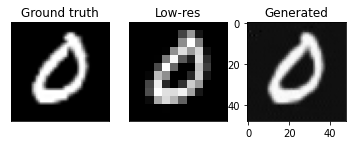

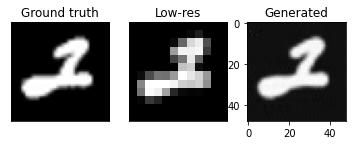

100%|██████████| 469/469 [00:51<00:00,  9.10it/s]


Discriminator loss is 0.004448687137216974, generator loss is 0.03949670668653226


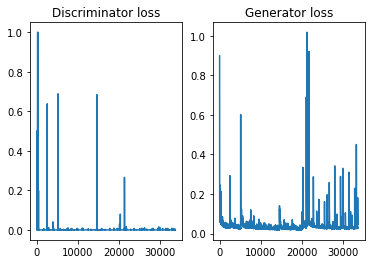

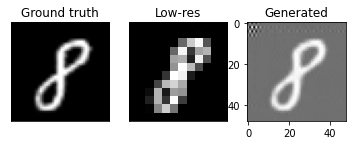

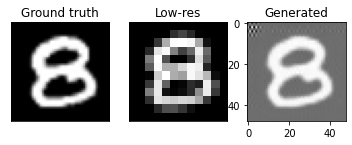

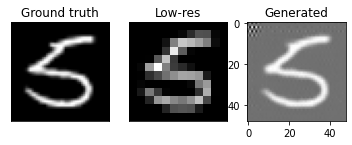

100%|██████████| 469/469 [00:51<00:00,  9.10it/s]


Discriminator loss is 0.004387864444151963, generator loss is 0.0393960279596101


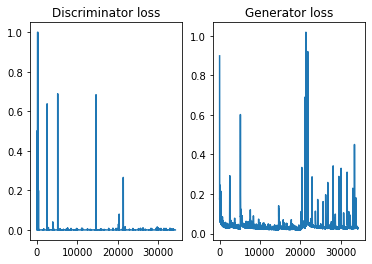

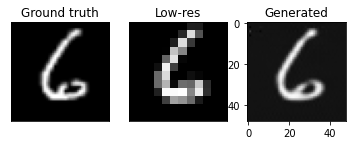

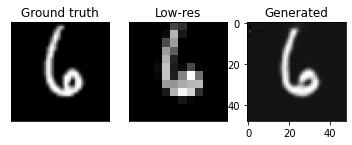

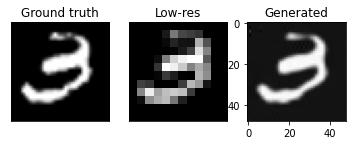

100%|██████████| 469/469 [00:51<00:00,  9.09it/s]


Discriminator loss is 0.004328575533737552, generator loss is 0.039229514566340044


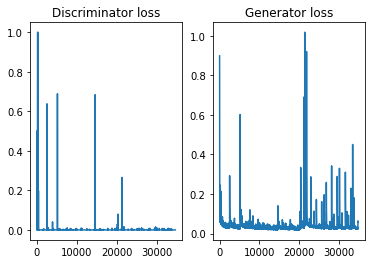

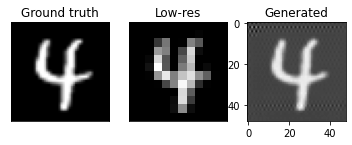

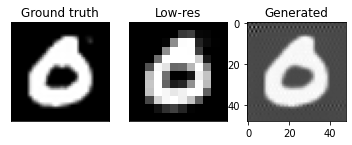

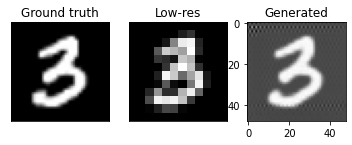

100%|██████████| 469/469 [00:51<00:00,  9.15it/s]


Discriminator loss is 0.004270862013009157, generator loss is 0.03907802238160189


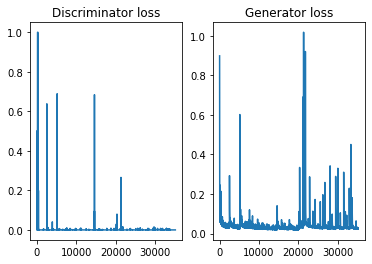

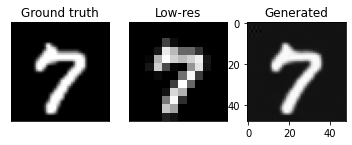

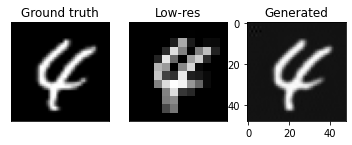

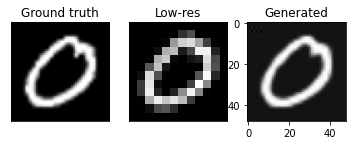

100%|██████████| 469/469 [00:50<00:00,  9.23it/s]


Discriminator loss is 0.004215832952355887, generator loss is 0.03926400952864718


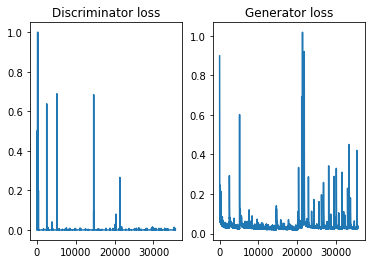

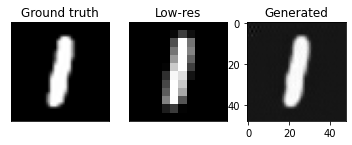

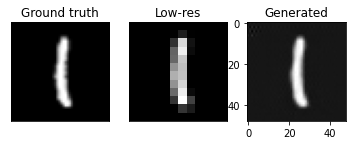

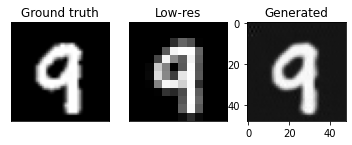

100%|██████████| 469/469 [00:50<00:00,  9.29it/s]


Discriminator loss is 0.0041626931608559035, generator loss is 0.03985855004110648


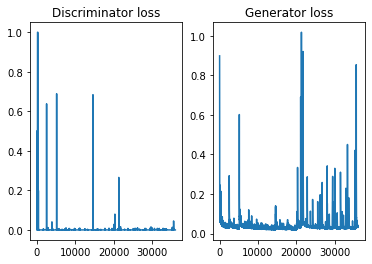

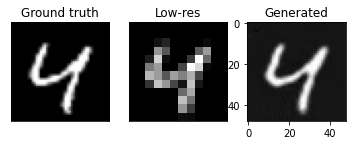

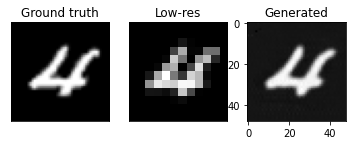

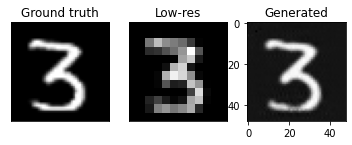

100%|██████████| 469/469 [00:50<00:00,  9.28it/s]


Discriminator loss is 0.004110062985380405, generator loss is 0.03993526639274348


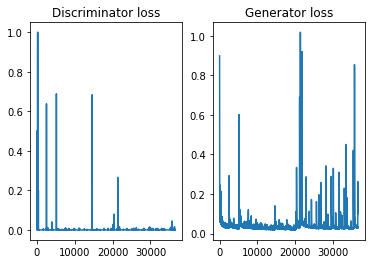

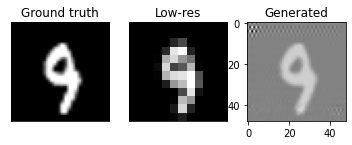

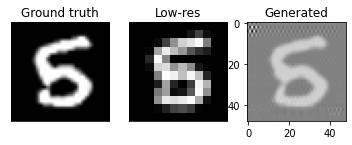

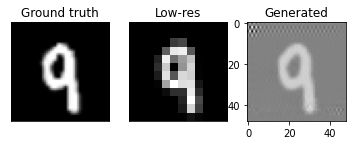

100%|██████████| 469/469 [00:50<00:00,  9.33it/s]


Discriminator loss is 0.004058043132611133, generator loss is 0.0399308485317031


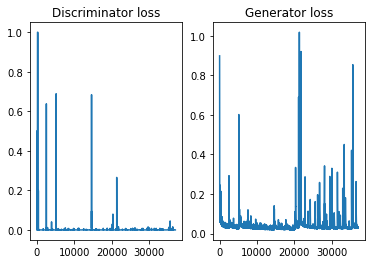

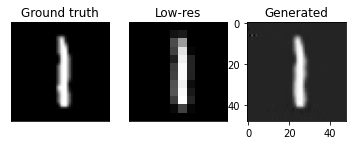

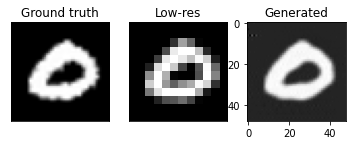

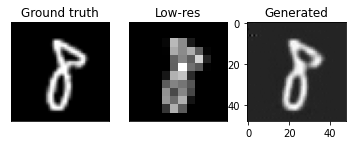

100%|██████████| 469/469 [00:50<00:00,  9.33it/s]


Discriminator loss is 0.004007317593453494, generator loss is 0.03979131334043269


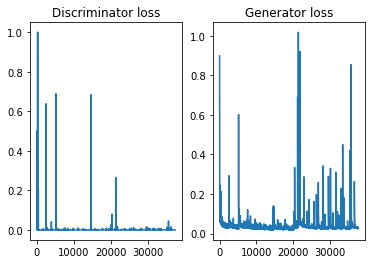

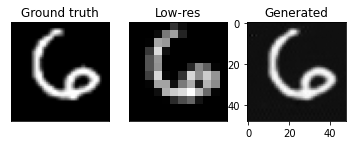

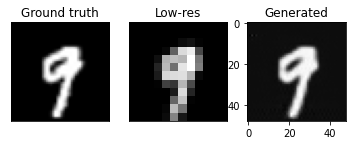

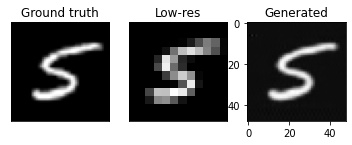

100%|██████████| 469/469 [00:50<00:00,  9.25it/s]


Discriminator loss is 0.003957851059610974, generator loss is 0.039704513044656144


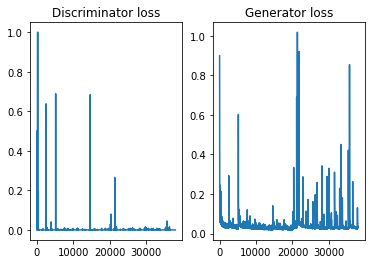

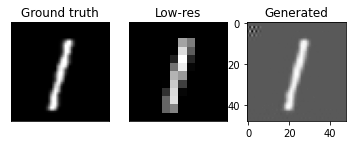

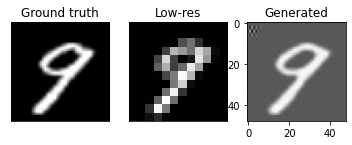

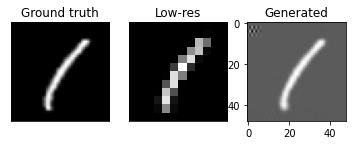

100%|██████████| 469/469 [00:51<00:00,  9.19it/s]


Discriminator loss is 0.003909783180238781, generator loss is 0.03956758797782284


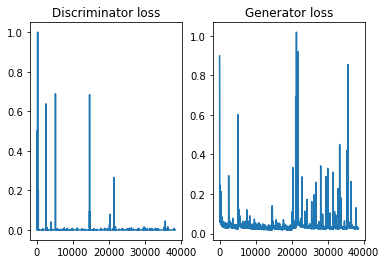

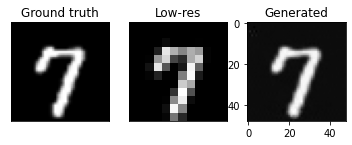

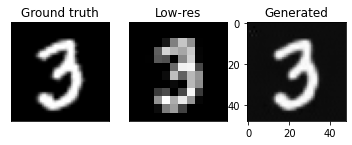

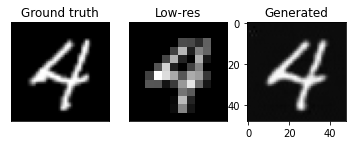

 93%|█████████▎| 434/469 [00:47<00:03,  9.14it/s]

KeyboardInterrupt: ignored

In [16]:
trainer.train()